Code for Autonomous Pipeline - It works

In [1]:
from pydantic import BaseModel
from typing import List, Optional
from langchain_core.documents import Document

class AgentState(BaseModel):
    goal: str

    # Planning
    task_plan: List[str] = []

    # Execution
    observations: List[str] = []

    # Construction
    draft_answer: str = ""

    # Evaluation
    reflection: Optional[str] = None
    feedback: Optional[str] = None

    # Control
    attempts: int = 0


In [13]:
### load llm models
import os
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-120b")
easy_work_llm = init_chat_model("groq:openai/gpt-oss-20b")

In [14]:
def planner(state: AgentState) -> AgentState:
    prompt = f"""
You are a planner.

Goal:
{state.goal}

Break this goal into clear, minimal sub-tasks.
Return as a numbered list.
"""
    plan_text = easy_work_llm.invoke(prompt).content
    tasks = [line.strip() for line in plan_text.split("\n") if line.strip()]

    return state.model_copy(update={"task_plan": tasks})


In [15]:
def executor(state: AgentState) -> AgentState:
    observations = []

    for task in state.task_plan:
        prompt = f"""
You are executing a sub-task.

Task:
{task}

Retrieve relevant information and report key findings.
"""
        obs = llm.invoke(prompt).content
        observations.append(obs[:600])

    return state.model_copy(update={
        "observations": observations,
        "attempts": state.attempts + 1
    })


In [16]:
def synthesizer(state: AgentState) -> AgentState:
    context = "\n\n".join(state.observations)

    prompt = f"""
Synthesize a coherent answer from the following observations.

Goal:
{state.goal}

Observations:
{context}

Draft answer:
"""
    answer = llm.invoke(prompt).content

    return state.model_copy(update={"draft_answer": answer})


In [17]:
def reflector(state: AgentState) -> AgentState:
    prompt = f"""
Evaluate the following draft answer.

Goal:
{state.goal}

Answer:
{state.draft_answer}

Is the answer correct and complete?
If not, explain what is missing.

Respond with:
PASS or FAIL
Explanation:
"""
    result = llm.invoke(prompt).content

    passed = result.strip().lower().startswith("pass")

    return state.model_copy(update={
        "reflection": result,
        "feedback": None if passed else result
    })


In [18]:
def route(state: AgentState) -> str:
    if state.reflection and state.reflection.lower().startswith("pass"):
        return "finalizer"

    if state.attempts >= 3:
        return "finalizer"

    return "executor"


In [19]:
def finalizer(state: AgentState) -> AgentState:
    return state


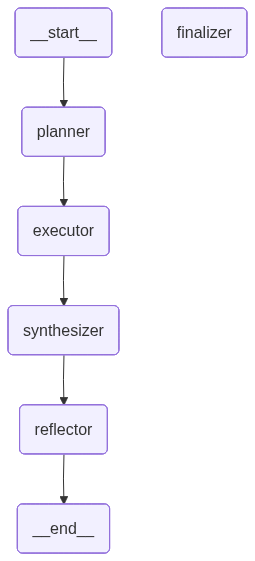

In [20]:
from langgraph.graph import StateGraph, END

builder = StateGraph(AgentState)

builder.add_node("planner", planner)
builder.add_node("executor", executor)
builder.add_node("synthesizer", synthesizer)
builder.add_node("reflector", reflector)
builder.add_node("finalizer", finalizer)

builder.set_entry_point("planner")

builder.add_edge("planner", "executor")
builder.add_edge("executor", "synthesizer")
builder.add_edge("synthesizer", "reflector")

builder.add_conditional_edges(
    "reflector",
    route
)

builder.add_edge("finalizer", END)

graph = builder.compile()
graph

In [21]:
state = AgentState(goal="How are transformer agents evolving in recent research?")
result = graph.invoke(state)

print(result["draft_answer"])


**Transformer agents – a quick definition**  
A *transformer agent* is any autonomous decision‑making system whose core reasoning, policy, or world‑model is a transformer‑style neural network (self‑attention, cross‑attention, or a close variant).  The transformer may be the sole “brain” (e.g., a language‑model‑only policy) or one component of a larger pipeline (perception → latent transformer → action decoder).  Because the term is deliberately broad, recent work can be grouped along a few orthogonal dimensions:

| Dimension | What it captures | Typical instantiation |
|-----------|------------------|-----------------------|
| **Back‑bone** | Pure decoder, encoder‑decoder, or hybrid (e.g., Perceiver‑IO) | GPT‑style decoder, T5‑style encoder‑decoder, Perceiver‑IO, Mamba‑style recurrent transformer |
| **Training regime** | Pre‑training on massive corpora → fine‑tuning / instruction‑tuning / RLHF | “Foundational” LLM pre‑training → task‑specific RL, RLHF, or LoRA adapters |
| **Modality*

## --lets start again fresh

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from typing import Any
### load llm models
import os
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-20b")

In [4]:
class RAGState(BaseModel):
    question: str
    # query decomposition and planning
    sub_questions : List[str] = []

    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: Any = ""
    feedback:str = ""
    revised: bool = False
    attempts: int = 0

In [5]:
# a. Query Planner: splits input question
def plan_query(state: RAGState) -> RAGState:
   
    prompt = f"""
    Break the following complex question into 2-3 sub-questions:
    
    Question: {state.question}
    Just reply with the sub questions no other things.
    Sub-questions:
    """
    result = llm.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question, sub_questions=sub_questions)

let this be search.py

In [3]:
from langchain.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

def get_search_tools():
    wiki = WikipediaQueryRun(
        api_wrapper=WikipediaAPIWrapper(top_k_results=3)
    )

    arxiv = ArxivQueryRun(
        api_wrapper=ArxivAPIWrapper(top_k_results=3)
    )

    tavily = TavilySearchResults(max_results=5)

    return [
        tool(
            name="wikipedia_search",
            func=wiki.run,
            description="Search general world knowledge from Wikipedia"
        ),
        tool(
            name="arxiv_search",
            func=arxiv.run,
            description="Search research papers from arXiv"
        ),
        tool(
            name="tavily_search",
            func=tavily.run,
            description="Search the web for recent or real-time information"
        )
    ]


this be compute.py

In [4]:
from langchain.tools import tool

@tool
def python(code: str) -> str:
    """
    Execute safe Python code for calculations or data analysis.
    """
    try:
        local_vars = {}
        exec(code, {}, local_vars)
        return str(local_vars)
    except Exception as e:
        return f"Error: {e}"

